# Bat Orientation Calls

The "Bat Orientation Calls" project aims to classify bat types using spectrograms in image format as input. The project utilizes both a decision tree classifier and a convolutional neural network (CNN) to achieve this task. The process followed in this Jupyter notebook is as follows:
<br></br>

**Loading and Preprocessing the Images with their Labels**

The first step in our project is to load the spectrogram images and their corresponding labels. Spectrograms are visual representations of sound that display the frequency content of an audio signal over time. These spectrograms are used as input data for the classification task. The images are preprocessed to ensure they are in a suitable format for our machine learning models.
<br></br>

**Data Exploration**

Before we begin modeling, we explore our data to understand its characteristics and distributions. This step helps us gain insights into the data and informs our choice of models and preprocessing steps.
<br></br>

**Setting up a Decision Tree Classifier**

We first set up a decision tree classifier, a machine learning algorithm that uses a tree-like model of decisions and their possible consequences. The decision tree classifier is trained on the features extracted from the spectrogram images, learning patterns and rules from the training data to make predictions on unseen data.
<br></br>

**Setting up a CNN Model**

Next, we set up a convolutional neural network (CNN), a deep learning model specifically designed for image classification tasks. CNNs are capable of automatically learning and extracting features from images, making them well-suited for our bat type classification task. The CNN model is trained on the spectrogram images, allowing it to learn complex patterns and relationships between different bat types.
<br></br>

**Analyzing and Comparing Results**

Finally, we analyze and compare the performance of the decision tree classifier and the CNN. This comparison provides insights into the effectiveness of traditional machine learning algorithms and deep learning models in the context of bat orientation calls classification.
<br></br>

By following this process, the project aims to explore and compare the performance of different machine learning approaches for bat type classification.

## Loading and Preprocessing the Images with their Labels

In [146]:
import numpy as np
import pandas as pd
import os

from PIL import Image

We define the function `load_images()`, which is responsible for loading and preprocessing our bat call images and their corresponding labels.

The general components include:

1. **Looping over image and label paths:** For each pair of image and label paths, we do the following:

2. **Printing the number of skipped images:** If any images were skipped because their labels were not found or not valid, we print out these counts for debugging purposes.

3. **Returning the images and labels as numpy arrays:** Finally, we convert our lists of images and labels to numpy arrays and return them. These arrays will be used for training our machine learning model.

This function is crucial because it prepares our data for the machine learning pipeline. It ensures that our images are in the correct format and that we have corresponding labels for each image.

In [147]:
def load_images(images_paths, labels_paths, valid_labels):
    images = []
    labels = []

    no_label_counter = 0
    unidentified_counter = 0

    for images_path, labels_path in zip(images_paths, labels_paths):

        # Load labels from csv file
        labels_df = pd.read_csv(labels_path, sep=';')
        labels_df['Filename'] = [file[:-3] + 'png' for file in labels_df['Filename']]

        for filename in os.listdir(images_path):
            # Load the image using PIL
            img_path = os.path.join(images_path, filename)
            img = Image.open(img_path)

            # Crop the image to the size of the spectrogram
            left, upper, right, lower = 55, 36, 389, 252
            img = img.crop((left, upper, right, lower))

            # Convert image to numpy array and normalize
            img_array = np.array(img)[:, :, :3] / 255.0

            # Extract class label from the CSV file based on the image filename
            label_row = labels_df.loc[labels_df['Filename'] == filename]
            
            if label_row.empty:
                no_label_counter += 1
                continue

            label = label_row['Species'].values[0]

            if label not in valid_labels:
                unidentified_counter += 1
                continue
                
            labels.append(label)
            images.append(img_array)
                

    if no_label_counter:
        print(f'Label not found for {no_label_counter} images : Images will not be used.')
    if unidentified_counter:
        print(f'Bat unidentified for {unidentified_counter} images : Images will not be used.')

    return np.array(images), np.array(labels)

Next, we define the paths to our image and label data. We also specify a list of valid labels that we're interested in. After running `load_images()`, we output the shapes of our image and label arrays to verify that they're of the same size.

In [148]:
images_folders = ['./Data/dataset1'] #, './Data/dataset2', './Data/dataset3'
labels_paths = ['./Data/dataset1_classified.csv'] #, './Data/dataset2_classified.csv', './Data/dataset3_classified.csv'

valid_labels = ['Bartfledermaus', 'Bechsteinfledermaus', 'Fransenfledermaus',
                'Große Hufeisennase', 'Hufeisennase', 'Mausohr',
                'Langohrfledermaus', 'Wasserfledermaus', 'Wimperfledermaus']

images, labels = load_images(images_folders, labels_paths, valid_labels)
print('Images shape: ', images.shape)
print('Labels shape: ', labels.shape)

Images shape:  (582, 216, 334, 3)
Labels shape:  (582,)


## Data Exploration

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt
import random

To get a sense of what our data looks like we randomly select 12 images from our dataset and visualize them.

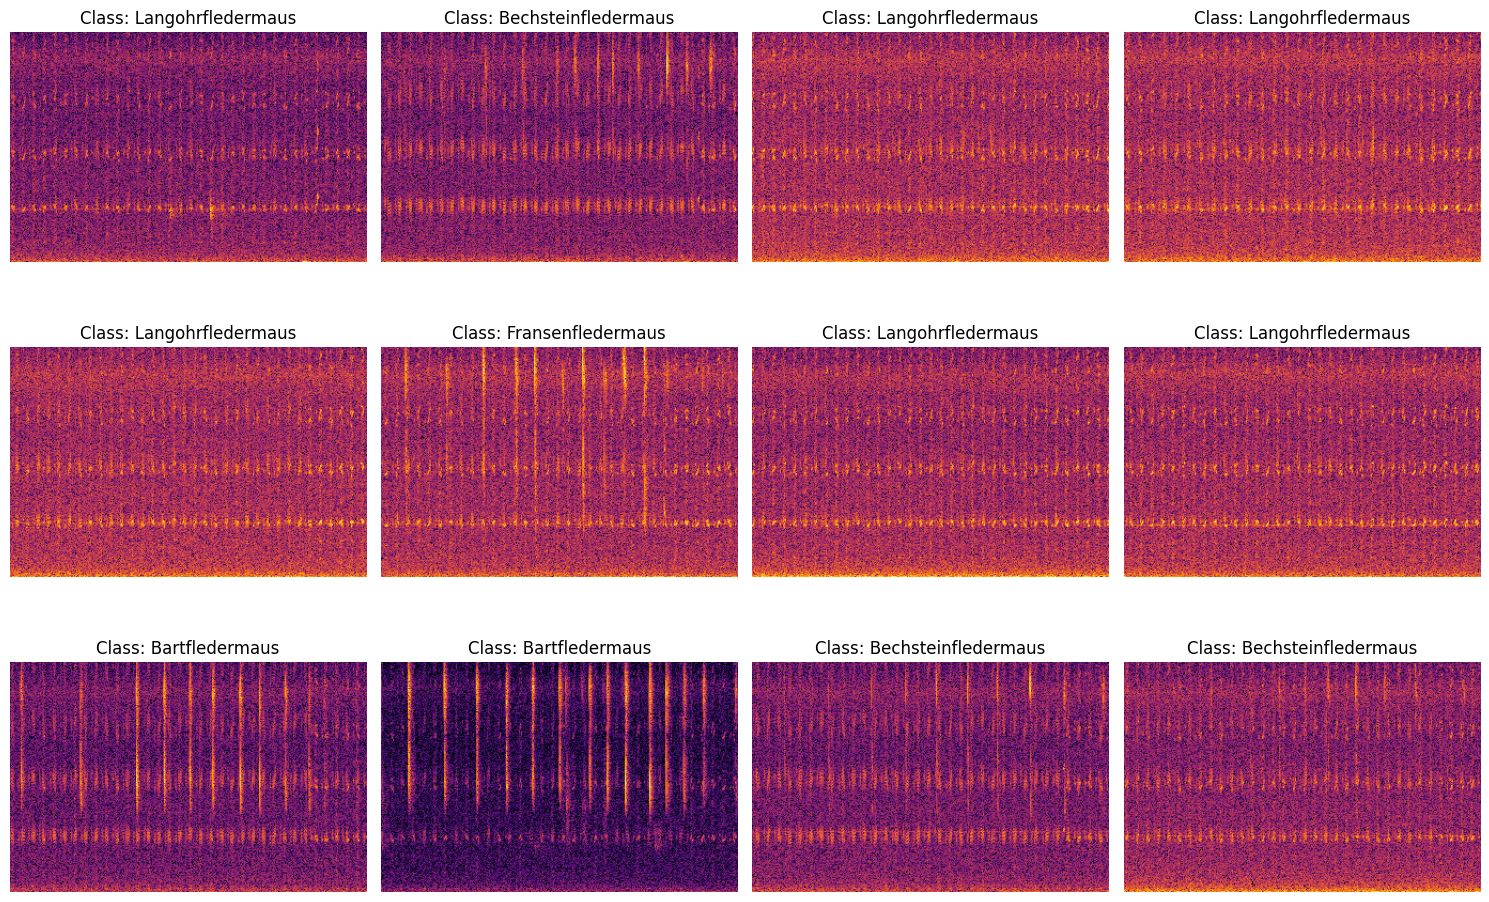

In [150]:
num_samples = 12
indices_to_visualize = random.sample(range(len(images)), num_samples)

num_cols = 4
num_rows = (num_samples + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, index in enumerate(indices_to_visualize):
    row = i // num_cols
    col = i % num_cols

    axes[row, col].imshow(images[index])
    axes[row, col].set_title(f'Class: {labels[index]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

We now use a bar chart to visualize the number of images we have for each bat type. By examining the distribution, we get a sense of the class distribution accross all bat types. With this, we  notice if we need to balance our data.

The exact counts showcase how underrepresented some of the bat types are.

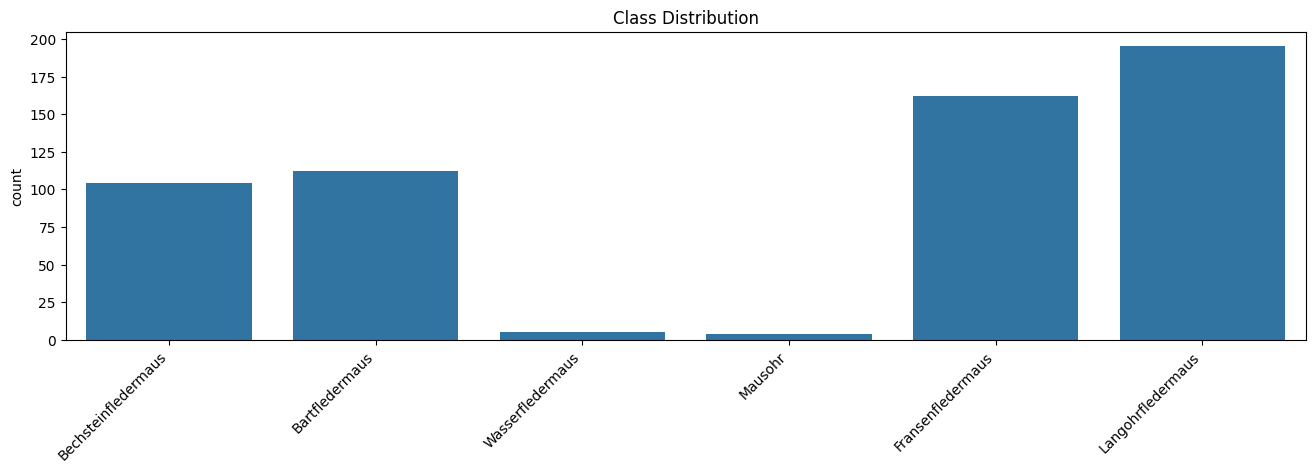

Langohrfledermaus      195
Fransenfledermaus      162
Bartfledermaus         112
Bechsteinfledermaus    104
Wasserfledermaus         5
Mausohr                  4
Name: count, dtype: int64


In [151]:
plt.figure(figsize=(16, 4))
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

label_counts = pd.Series(labels).value_counts()
print(label_counts)

Performing some basic statistical analysis on our images and labels gives us an idea about the overall brightness and contrast of our images.

We also check for missing values in our labels and images. Luckily, none need to be handled.

In [152]:
print('Mean of images: ', np.mean(images))
print('Std deviation of images: ', np.std(images))

empty_string_indices = labels == ''
print('Missing values in labels: ', np.sum(empty_string_indices))
print('Missing values in images: ', np.isnan(images).sum())

Mean of images:  0.3200254439126128
Std deviation of images:  0.22617266786506793
Missing values in labels:  0
Missing values in images:  0


## Setting up a Decision Tree Classifier

In [1]:
#TODO

## Setting up a CNN Model

We're now transitioning from data exploration to model building. We've chosen to use a Convolutional Neural Network (CNN) for our task. CNNs are particularly effective for image classification tasks because they can automatically learn and extract features from images, which can be more effective than manually engineered features.

We'll be using the Keras library to build our CNN.

In [153]:
import tensorflow as tf
from tensorflow import keras

from keras import layers, models

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.preprocessing.image import ImageDataGenerator

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import clear_output

We first convert our labels to numerical values using a LabelEncoder and afterwards split our data into training, validation, and testing sets.

The training set will be used to train our model, the validation set will be used to evaluate our model during training, and the testing set will be used to evaluate our model after training.

In [154]:
# Converting to numerical labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.3, random_state=42)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

As we noticed huge class imbalances during data exploration we also calculate class weights to balance our data. We'll use these weights during training to ensure that our model doesn't become biased towards the majority class.

In [ ]:
# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(encoded_labels),
                                                  y=encoded_labels)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

In this cell, we're setting up data augmentation using Keras's `ImageDataGenerator`to enable us to significantly increase the diversity of data available for training models, without actually collecting new data. 

Our augmentation techniques include slight shifts in width and height, and channel shifts.
We decided against horizontal and vertical flips as well as rotation as this would totally change the information inside the spectrogram.

This technique can help the model generalize better to new data, as it provides a way of artificially introducing sample variability by applying random image changes. 

In [155]:
# Data Augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    width_shift_range = 0.025,
    height_shift_range = 0.015,
    channel_shift_range= 0.2
)

datagen.fit(X_train)

To see the types of transformations our data augmentation is applying, we generate a few augmented images from our training set and plot them next to the original images. This allows us to ensure they're sensible for our task.

Using this we can tune the parameters of our data augmentation to ensure that our augmentation techniques are providing a good variety of images for our model to learn from, without distorting the images.

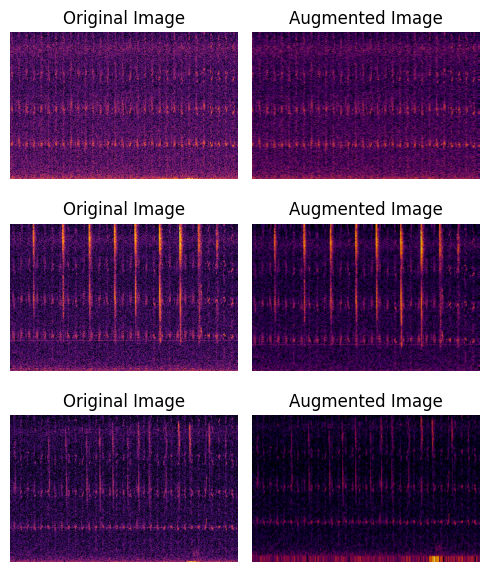

In [156]:
# Generate augmented images
augmented_images = datagen.flow(X_train, batch_size=1, shuffle=False)

# Plot original and augmented images
num_samples = 3
fig, axes = plt.subplots(num_samples, 2, figsize=(5, 6))

for i in range(num_samples):
    # Original Image
    original_image = X_train[i]
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # Augmented Image
    augmented_image = augmented_images.next()[0]
    axes[i, 1].imshow(augmented_image)
    axes[i, 1].set_title('Augmented Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

Now we have to define our Convolutional Neural Network (CNN) model. We're using Keras's `Sequential` API, which allows us to stack layers on top of each other. Here's why we chose these specific layers:

1. **Conv2D layers:** These are the convolutional layers that will learn the features in our images. We're using 3x3 filters, which is a common choice. We're also using the ReLU activation function, which helps the model learn complex patterns. The number of filters in each Conv2D layer is a hyperparameter that we'll tune.

2. **MaxPooling2D layers:** These layers reduce the spatial dimensions of our data, which makes the model more computationally efficient and helps it detect features regardless of their position in the image. We're using 2x2 pooling windows.

3. **Flatten layer:** This layer reshapes our 3D data into 1D data so it can be fed into the dense layer.

4. **Dense layers:** These are fully connected layers that will learn patterns in the features extracted by the Conv2D layers.

5. **Dropout layers:** These layers randomly set a fraction of the input units to 0 during training, which helps prevent overfitting.

6. **Output layer:** This layer outputs the probabilities of each class. We're using the softmax activation function, which ensures that the output probabilities sum to 1.

Finally, we compile our model with the Adam optimizer and the sparse categorical crossentropy loss function. We're also tuning the learning rate of our optimizer.

We're using the `RandomSearch` class from Keras Tuner to tune our hyperparameters. This class will randomly select combinations of hyperparameters for the number of filters in each Conv2D layer, the size of the dense layer, the amount of dropout for each Dropout layer as well as the general learning rate. Afterwards, it will train the model on random combinations.

We're aiming to maximize validation accuracy. The results will be saved in the specified directory.

In [157]:
# Define a function to build the model with hyperparameters
def build_model(hp):
    model = models.Sequential()

    model.add(layers.Conv2D(hp.Int('conv1_units', min_value=16, max_value=64, step=16), (3, 3), activation='relu', input_shape=(216, 334, 3)))
    model.add(layers.Dropout(hp.Float('dropout_conv1', min_value=0.05, max_value=0.2, step=0.05)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_conv2', min_value=0.05, max_value=0.2, step=0.05)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(hp.Int('conv3_units', min_value=64, max_value=256, step=64), (3, 3), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_conv3', min_value=0.05, max_value=0.2, step=0.05)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_dense', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')), 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Instantiate the tuner
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10, directory='./cnn-model/tuner_results', project_name='cnn_tuner',
                     overwrite=True)

To make our tuner work more effectively, we're defining several callbacks to use during model training. Callbacks are functions that can be applied at certain stages of the training process, such as at the start or end of an epoch, batch, or training session. Here's why we chose these specific callbacks:

1. **EarlyStopping:** This callback will stop training when a monitored quantity has stopped improving. We're monitoring the validation loss and will stop training if it doesn't improve for 10 epochs. This helps prevent overfitting and reduces computational waste.

2. **LowAccuracy:** This is a custom callback we've defined. It stops training if the validation accuracy is below a certain threshold for a certain number of epochs. This can save time if the chosen parameters are not effective for training the model.

3. **ModelCheckpoint:** This callback saves the model after every epoch. We're saving only the model that has the best validation accuracy. This allows us to use the best model even if training is stopped early or if the model's performance decreases in later epochs.

4. **PlotInfo:** This is another custom callback we've defined. It plots the training and validation loss and accuracy after each epoch. This allows us to visually monitor our model's performance during training and can help us identify issues like overfitting or underfitting.

By using these callbacks, we can have more control over the training process and can make it more efficient and effective.

In [158]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Define low accuracy callback
class LowAccuracy(keras.callbacks.Callback):
    def __init__(self, threshold, patience):
        super(LowAccuracy, self).__init__()
        self.threshold = threshold
        self.patience = patience
        self.counter = 0

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy', 0)
        if val_accuracy < self.threshold:
            self.counter += 1
            if self.counter >= self.patience:
                self.model.stop_training = True

low_accuracy = LowAccuracy(threshold=0.02, patience=5)


# Define model checkpoint callback
checkpoint_path = './cnn-model/model_checkpoint.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')


# Define plot callback
class PlotInfo(keras.callbacks.Callback):
    def __init__(self):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []

        self.best_val_loss = float('inf')
        self.best_val_loss_epoch = 1
        self.best_val_accuracy = 0
        self.best_val_accuracy_epoch = 1

        self.epoch = 1
        self.logs = []

    def on_epoch_end(self, epoch, logs=None):
        self.logs.append(logs)
        self.x.append(self.epoch)

        self.losses.append(logs.get('loss', 0))
        self.val_losses.append(logs.get('val_loss', 0))
        self.accuracy.append(logs.get('accuracy', 0))
        self.val_accuracy.append(logs.get('val_accuracy', 0))

        # Check if current val_loss is the best so far
        if logs.get('val_loss') < self.best_val_loss:
            self.best_val_loss = logs.get('val_loss')
            self.best_val_loss_epoch = self.epoch

        # Check if current val_accuracy is the best so far
        if logs.get('val_accuracy') > self.best_val_accuracy:
            self.best_val_accuracy = logs.get('val_accuracy')
            self.best_val_accuracy_epoch = self.epoch

        self.epoch += 1
        clear_output(wait=True)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Subplot for loss
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.scatter(self.best_val_loss_epoch, self.best_val_loss, marker='o', color='red', label=f'best val_loss ({self.best_val_loss:.3f})')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.legend()

        # Subplot for accuracy
        ax2.plot(self.x, self.accuracy, label="accuracy")
        ax2.plot(self.x, self.val_accuracy, label="val_accuracy")
        ax2.scatter(self.best_val_accuracy_epoch, self.best_val_accuracy, marker='o', color='green', label=f'best val_accuracy ({self.best_val_accuracy:.3f})')
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('accuracy')
        ax2.legend()

        fig.suptitle(f'CNN tuner - Epoch {self.epoch - 1}', fontsize=16)
        plt.tight_layout()
        plt.show()

plot_info = PlotInfo()

Now, let's start the hyperparameter search process. We're using the `search` method of our tuner object, which will train our model with different combinations of hyperparameters and find the best ones.

We're passing our augmented training and validation data to the method. We're also specifying the number of epochs to train for, the class weights to use, and the callbacks we defined earlier.

This process can take a long time (around 16 hours when including all datasets), depending on the number of hyperparameters we're tuning and the number of epochs we're training for. But at the end, we'll have a model that's mostly optimized for our specific task.

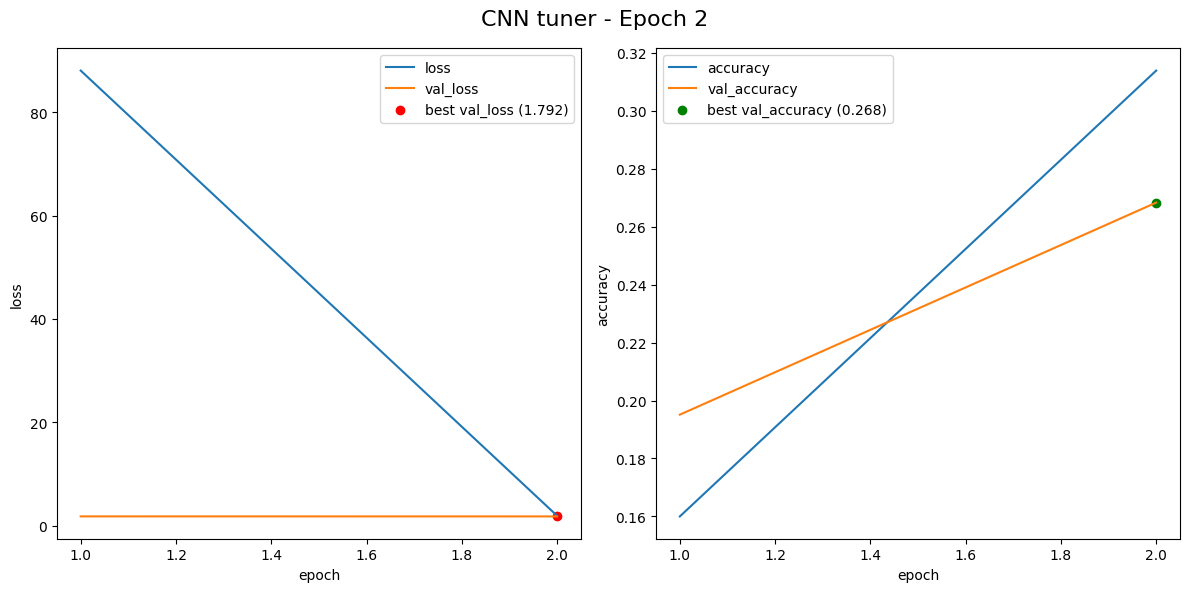

11/11 [==============================] - 61s 5s/step - loss: 1.9279 - accuracy: 0.3138 - val_loss: 1.7925 - val_accuracy: 0.2683
Epoch 3/3
 1/11 [=>............................] - ETA: 41s - loss: 3.4752 - accuracy: 0.4375

KeyboardInterrupt: 

In [159]:
# Search for the best hyperparameters
tuner.search(datagen.flow(X_train, y_train, batch_size=32),
             epochs=50,
             validation_data=datagen.flow(X_val, y_val, batch_size=32),
             class_weight=class_weights_dict,
             callbacks=[early_stopping, low_accuracy, plot_info, model_checkpoint])

Of all the trained models from our hyperparameter search, we obviously want to retrieve the best model. The `get_best_models` method of our tuner object returns the top models, ranked by their performance on the validation data. We're only interested in the top model, so we specify `num_models=1`.

In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

To get a sense of how large the model is, we use the `summary` method of our model object. This shows us the layers in our model and the number of parameters in each layer.

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 214, 332, 16)      448       
                                                                 
 dropout (Dropout)           (None, 214, 332, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 107, 166, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 105, 164, 96)      13920     
                                                                 
 dropout_1 (Dropout)         (None, 105, 164, 96)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 52, 82, 96)        0         
 g2D)                                                   

After extracting the best found model, we train it again to give it a chance to further learn from our data and improve its performance.

The `fit` method returns a history object, which contains information about the training process, such as the loss and accuracy values at each epoch. We'll use this object later to plot our training and validation loss and accuracy. 

In [ ]:
# Train the best model again
history = best_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                        epochs=50,
                        class_weight=class_weights_dict,
                        validation_data=datagen.flow(X_val, y_val, batch_size=32),
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
66/66 [==============================] - 115s 2s/step - loss: 0.2295 - accuracy: 0.8168 - val_loss: 0.8594 - val_accuracy: 0.7235
Epoch 2/50
66/66 [==============================] - 112s 2s/step - loss: 0.2175 - accuracy: 0.8253 - val_loss: 0.9044 - val_accuracy: 0.7197
Epoch 3/50
66/66 [==============================] - 113s 2s/step - loss: 0.1948 - accuracy: 0.8329 - val_loss: 0.7789 - val_accuracy: 0.7708
Epoch 4/50
66/66 [==============================] - 113s 2s/step - loss: 0.2480 - accuracy: 0.8030 - val_loss: 0.9178 - val_accuracy: 0.7330
Epoch 5/50
66/66 [==============================] - 113s 2s/step - loss: 0.3352 - accuracy: 0.7931 - val_loss: 0.9843 - val_accuracy: 0.6742
Epoch 6/50
66/66 [==============================] - 112s 2s/step - loss: 0.2112 - accuracy: 0.8220 - val_loss: 0.8053 - val_accuracy: 0.7973
Epoch 7/50
66/66 [==============================] - 112s 2s/step - loss: 0.1887 - accuracy: 0.8423 - val_loss: 0.8113 - val_accuracy: 0.7633
Epoch 8/50
66

Using the history object, we plot the training and validation loss and accuracy. This allows us to visually monitor our model's performance during training and can help us identify issues like overfitting or underfitting.

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

After the best model trained again, we save it to a file. This allows us to load the model later without having to retrain it.

In [ ]:
# Save the trained model
best_model.save('./cnn-model/best_model.keras')

Loading the model at this point allows us to skip the hyperparameter search process and go straight to model evaluation. This is useful if we want to try out different evaluation metrics or if we want to evaluate the model on different datasets.

In [ ]:
# Load the trained model
cnn_model = keras.models.load_model('./cnn-model/best_model.keras')

## Analyzing and Comparing Results

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

To evaluate the performance of our trained model on the test set, we use the `evaluate` method of our model object. This method returns the loss and accuracy values for the model in test mode.

In [ ]:
# Evaluate the best model on the test set
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)

36/36 [==============================] - 8s 196ms/step - loss: 0.6980 - accuracy: 0.8118


To better visualize the performance of our model on the test set for each class individually, we generate a confusion matrix.

We first get the predicted class labels from our model by calling the `predict` method and then taking the argmax of the output probabilities. We also convert our true labels to integer format.

We then generate the confusion matrix using the `confusion_matrix` function from sklearn. This function compares the predicted and true labels and counts the number of times each class was predicted for each true class.

By examining the confusion matrix, we can see which classes our model is good at predicting and which ones it struggles with. This can help us identify areas where our model could be improved.

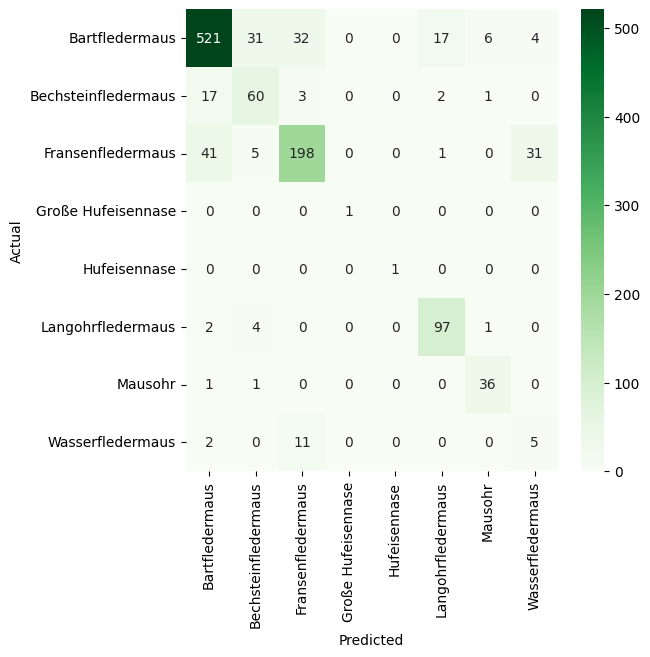

In [ ]:
all_classes = label_encoder.classes_

y_pred_probabilities = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)
y_test_int = np.argmax(keras.utils.to_categorical(y_test), axis=1)

# Extract unique classes present in the test dataset
unique_classes_in_test = np.unique(y_test_int)

# Filter the all_classes list to include only those present in the test dataset
target_classes = [all_classes[i] for i in unique_classes_in_test]

# Generate confusion matrix
confusion_m = confusion_matrix(y_test_int, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_m, annot=True, fmt='d', cmap='Greens', xticklabels=target_classes, yticklabels=target_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

To get a more detailed view of our model's performance, we generate a classification report. This presents us the precision, recall, f1-score, and support for each class.

We first convert our integer labels back to string labels using the inverse_transform method of our LabelEncoder. This is because the classification_report function expects string labels.

We then generate the classification report using the `classification_report` function from sklearn.

In [ ]:
# Convert the integer labels to string labels using the label_encoder
y_test_int_str = label_encoder.inverse_transform(y_test_int)
y_pred_str = label_encoder.inverse_transform(y_pred)

# Classification report
print(classification_report(y_test_int_str, y_pred_str, target_names=target_classes, zero_division=1))

                     precision    recall  f1-score   support

     Bartfledermaus       0.89      0.85      0.87       611
Bechsteinfledermaus       0.59      0.72      0.65        83
  Fransenfledermaus       0.81      0.72      0.76       276
 Große Hufeisennase       1.00      1.00      1.00         1
       Hufeisennase       1.00      1.00      1.00         1
  Langohrfledermaus       0.83      0.93      0.88       104
            Mausohr       0.82      0.95      0.88        38
   Wasserfledermaus       0.12      0.28      0.17        18

           accuracy                           0.81      1132
          macro avg       0.76      0.81      0.78      1132
       weighted avg       0.83      0.81      0.82      1132

